In [41]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0,'/media/csivsw/crossOS/playground/friends_of_tracking/src/friends_of_tracking/LaurieOnTracking')
%matplotlib inline

import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import modin.pandas as pd
pd.options.display.max_columns = None

from tqdm.auto import tqdm

tqdm.pandas(desc="my bar!")

In [2]:
# set up initial path to data
DATADIR = '/media/csivsw/crossOS/playground/friends_of_tracking/datahub/metrica_sports/sample-data/data'
game_id = 2 # let's look at sample match 2

# first get model parameters
params = mpc.default_model_params(3)

In [3]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)


Reading team: home
Reading team: away


## Plot the goal of interest

In [4]:
def get_goal_lead_up(goal_id,events):
    team = events.loc[goal_id,'Team']
    for i,row in events.iloc[goal_id-1::-1,:2].iterrows():
        # if row['Type']!='PASS':
        if row['Team']!=team:
            break
    return events.iloc[i+1:goal_id+1,:]

In [5]:
# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


In [6]:
g1 = get_goal_lead_up(198,events) # Home
g2 = get_goal_lead_up(823,events) # Away
g3 = get_goal_lead_up(1118,events) # Home
g4 = get_goal_lead_up(1671,events) # Away
g5 = get_goal_lead_up(1723,events) # Home

print (g1.shape, g2.shape, g3.shape, g4.shape, g5.shape)

(11, 14) (8, 14) (12, 14) (2, 14) (2, 14)


We can look at the first three goals may be. As they have at least a chain of 5+ events (may be even all passes)

#### Goal 1 : HOME -> EVENT 198

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f78d8177c50>)

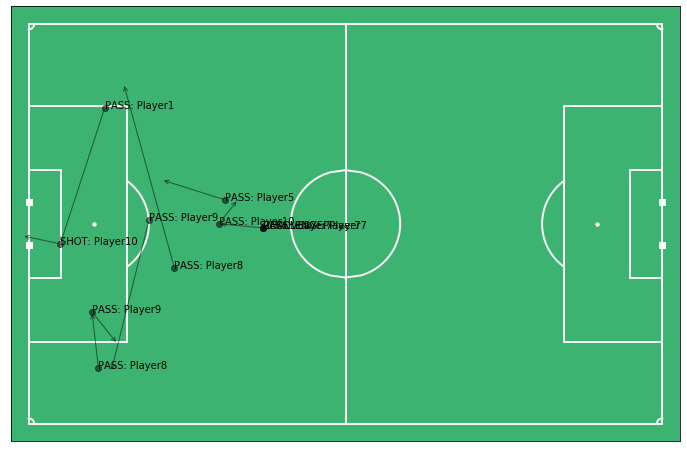

In [7]:
# plot the 3 events leading up to the first goal
mviz.plot_events( g1, color='k', indicators = ['Marker','Arrow'], annotate=True )

In [8]:
# generate a video of this g1 chain
# PLOTDIR = '/media/csivsw/crossOS/playground/friends_of_tracking/output/'
# mviz.save_match_clip(tracking_home.iloc[11641:12212],
#                      tracking_away.iloc[11641:12212],
#                      PLOTDIR,fname='home_goal_1',include_player_velocities=False, 
#                      params=params,events=events, pitch_control=True,attacking='Home')

In [9]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="/media/csivsw/crossOS/playground/friends_of_tracking/output/home_goal_1.mp4" type="video/mp4">
    </video>
""")

In [10]:
g1

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
188,Home,CHALLENGE,TACKLE-WON,1,11641,465.64,11641,465.64,Player7,NaN,-13.78,-0.68,NaN,NaN
189,Home,RECOVERY,THEFT,1,11641,465.64,11641,465.64,Player7,NaN,-13.78,-0.68,NaN,NaN
190,Home,PASS,NaN,1,11647,465.88,11685,467.40,Player7,Player10,-13.78,-0.68,-21.20,-0.00
191,Home,PASS,NaN,1,11685,467.40,11703,468.12,Player10,Player5,-21.20,-0.00,-18.02,4.08
192,Home,PASS,NaN,1,11721,468.84,11744,469.76,Player5,Player9,-20.14,4.08,-30.74,7.48
193,Home,PASS,NaN,1,11810,472.40,11885,475.40,Player9,Player8,-32.86,0.68,-39.22,-25.16
194,Home,PASS,NaN,1,11958,478.32,11976,479.04,Player8,Player9,-41.34,-24.48,-42.40,-14.96
195,Home,PASS,NaN,1,11976,479.04,11994,479.76,Player9,Player8,-42.40,-14.96,-38.16,-20.40
196,Home,PASS,NaN,1,12069,482.76,12146,485.84,Player8,Player1,-28.62,-7.48,-37.10,23.80
197,Home,PASS,CROSS,1,12180,487.20,12202,488.08,Player1,Player10,-40.28,19.72,-47.70,-3.40


In [11]:
# off the ball run...
# we can assume that an OTB run is begun 3-5 seconds before a pass is completed.
# so in g1, if we look at event 196, pass from #8 to #1 ended at (-37.10,23.80) at f12146
# while the pass began at f1206, we should track the movement of #1 from a 100 frames before.
# f12146 - 100 = f12046
# we can plot the PPCF of each player for these 100 frames

In [77]:
event_id = 196
target_position = np.array([g1.loc[event_id,['End X']],g1.loc[event_id,['End Y']]])
team = g1.loc[event_id].Team

pass_start_frame = g1.loc[event_id]['Start Frame']
pass_end_frame = g1.loc[event_id]['End Frame']
n=500
# lookup n frames prior to pass end frame
hometeam = tracking_home.loc[pass_end_frame-n:pass_end_frame]
awayteam = tracking_away.loc[pass_end_frame-n:pass_end_frame]

pitch_control_xy_df = pd.DataFrame()
for frame in tqdm(range(pass_end_frame-n,pass_end_frame)):
    # get the details of the frame: team in possession, ball_start_position)
    ball_start_pos = np.array(hometeam.loc[frame,['ball_x', 'ball_y']])
    # ball_start_pos = np.array([g1.loc[event_id]['Start X'],g1.loc[event_id]['Start Y']])
# print (np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed'])
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if team=='Home':
        attacking_players = mpc.initialise_players(hometeam.loc[frame],'Home',params)
        defending_players = mpc.initialise_players(awayteam.loc[frame],'Away',params)
        opp='Away'
    elif team=='Away':
        defending_players = mpc.initialise_players(hometeam.loc[frame],'Home',params)
        attacking_players = mpc.initialise_players(awayteam.loc[frame],'Away',params)
        opp='Home'
    else:
        assert False, "Team in possession must be either home or away"
    

    PPCFatt, PPCFdef, Patt, Pdef= mpc.calculate_pitch_control_at_target(target_position, 
                                      attacking_players, defending_players, 
                                      ball_start_pos, params, 
                                      return_individual=True)
    
    pitch_control_xy_df.loc[frame,'PPCFatt'] = PPCFatt
    pitch_control_xy_df.loc[frame,'PPCFdef'] = PPCFdef
    pitch_control_xy_df.loc[frame,'attacking'] = team
    for pid, pc in Patt.items():
        pitch_control_xy_df.loc[frame,"%s_%s_%s" % (team,pid, 'pc')] = pc
    for pid, pc in Pdef.items():
        pitch_control_xy_df.loc[frame,"%s_%s_%s" % (opp,pid, 'pc')] = pc


100%|██████████| 500/500 [00:45<00:00, 11.01it/s]


In [ ]:
sum(Patt.values()),PPCFatt

In [ ]:
for pid, pc in Patt.items():
    print (pid, pc,"%s_%s_%s" % (team,pid, 'pc') )

In [164]:
pitch_control_xy_df.head(3)

,PPCFatt,PPCFdef,attacking,Home_1_pc,Home_10_pc,Home_2_pc,Home_3_pc,Home_4_pc,Home_5_pc,Home_6_pc,Home_7_pc,Home_9_pc,Away_15_pc,Away_16_pc,Away_17_pc,Away_18_pc,Away_19_pc,Away_20_pc,Away_21_pc,Away_22_pc,Away_24_pc,Away_23_pc
11646,0.585853,0.404159,Home,0.004475,0.009998,0.000054,0.008880,0.208733,0.053080,0.126878,0.085872,0.000006,0.002047,0.003637,0.000991,0.000005,0.007028,0.003010,0.237166,0.096508,0.053767,NaN
11647,0.590758,0.404405,Home,0.004379,0.010595,0.000057,0.008732,0.209968,0.054480,0.130496,0.084767,0.000006,0.002067,0.003684,0.001046,0.000005,0.006771,0.003150,0.239176,0.096646,0.051861,NaN
11648,0.589468,0.400584,Home,0.004216,0.011037,0.000059,0.008456,0.209162,0.055144,0.132967,0.082848,0.000006,0.002054,0.003665,0.001079,0.000006,0.006427,0.003253,0.239219,0.095428,0.049452,NaN


In [180]:
hometeam.loc[pass_end_frame-n:pass_end_frame]

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y,Home_1_vx,Home_1_vy,Home_1_speed,Home_10_vx,Home_10_vy,Home_10_speed,Home_11_vx,Home_11_vy,Home_11_speed,Home_12_vx,Home_12_vy,Home_12_speed,Home_13_vx,Home_13_vy,Home_13_speed,Home_14_vx,Home_14_vy,Home_14_speed,Home_2_vx,Home_2_vy,Home_2_speed,Home_3_vx,Home_3_vy,Home_3_speed,Home_4_vx,Home_4_vy,Home_4_speed,Home_5_vx,Home_5_vy,Home_5_speed,Home_6_vx,Home_6_vy,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11646,1,465.84,36.26154,1.73604,-0.30104,10.37272,10.45584,14.45612,8.12702,-4.09768,-2.90016,-8.80124,-14.04182,4.78788,-7.60020,3.36872,-13.51394,-0.69156,-7.88322,-16.58112,-18.55424,22.53860,-24.18920,-0.59704,NaN,NaN,NaN,NaN,NaN,NaN,-13.46094,-0.70516,3.789500,-1.350286,4.022882,2.816571,-0.667857,2.894669,0.374786,-0.988429,1.057098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.813357,-2.295000,2.924943,2.748429,-0.677571,2.830718,0.041643,-0.777143,0.778258,2.718143,-1.534857,3.121552,3.569929,-3.018714,4.675150,-1.336357,0.172429,1.347435,4.285429,0.429857,4.306933,0.988071,-1.372143,1.690876
11647,1,465.88,36.27744,1.69864,-0.14946,10.32784,10.52686,14.36024,8.23620,-4.12352,-2.90016,-8.83524,-13.93900,4.72872,-7.45816,3.24836,-13.57012,-0.67864,-7.71362,-16.56548,-18.51926,22.47944,-24.07684,-0.62220,NaN,NaN,NaN,NaN,NaN,NaN,-13.51500,-0.69088,3.759214,-1.260429,3.964892,2.824143,-0.626571,2.892814,0.355857,-0.959286,1.023163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.767929,-2.333857,2.927876,2.706786,-0.701857,2.796300,0.007571,-0.862143,0.862176,2.570500,-1.527571,2.990141,3.528286,-3.013857,4.640273,-1.415857,0.189429,1.428473,4.251357,0.332714,4.264356,0.889643,-1.389143,1.649601
11648,1,465.92,36.28804,1.65784,0.00000,10.28228,10.59682,14.26436,8.34326,-4.15072,-2.90122,-8.87264,-13.84254,4.66888,-7.31930,3.12664,-13.63054,-0.66776,-7.54402,-16.55528,-18.48958,22.41824,-23.96342,-0.64532,NaN,NaN,NaN,NaN,NaN,NaN,-13.66976,-0.66640,3.728929,-1.168143,3.907616,2.827929,-0.582857,2.887369,0.329357,-0.942286,0.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.726286,-2.353286,2.918564,2.665143,-0.714000,2.759127,-0.022714,-0.947143,0.947415,2.422857,-1.522714,2.861625,3.482857,-3.023571,4.612188,-1.468857,0.208857,1.483632,4.213500,0.242857,4.220493,0.779857,-1.430429,1.629203
11649,1,465.96,36.29758,1.61636,0.14734,10.23468,10.66360,14.16712,8.44926,-4.17860,-2.90440,-8.91480,-13.75138,4.60700,-7.18044,3.00424,-13.68990,-0.66164,-7.37866,-16.54984,-18.46202,22.36180,-23.85106,-0.66572,NaN,NaN,NaN,NaN,NaN,NaN,-13.87964,-0.64192,3.691071,-1.095286,3.850151,2.835500,-0.541571,2.886756,0.299071,-0.942286,0.988608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680857,-2.372714,2.907758,2.631071,-0.723714,2.728791,-0.045429,-1.041857,1.042847,2.267643,-1.515429,2.727403,3.437429,-3.021143,4.576376,-1.506714,0.228286,1.523910,4.171857,0.143286,4.174317,0.670071,-1.469286,1.614867
11650,1,466.00,36.30712,1.57624,0.29362,10.19592,10.72826,14.06920,8.55208,-4.21124,-2.90652,-8.95832,-13.66552,4.54376,-7.04582,2.88456,-13.75456,-0.65348,-7.21330,-16.55052,-18.43870,22.30468,-23.73658,-0.68408,NaN,NaN,NaN,NaN,NaN,NaN,-14.08952,-0.61676,3.653214,-1.003000,3.788401,2.835500,-0.497857,2.878875,0.272571,-0.942286,0.980917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.639214,-2.372714,2.883886,2.581857,-0.735857,2.684674,-0.060571,-1.146286,1.147885,2.127571,-1.508143,2.607883,3.388214,-3.001714,4.526620,-1.540786,0.196714,1.553292,4.118857,0.046143,4.119116,0.556500,-1.488714,1.589328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

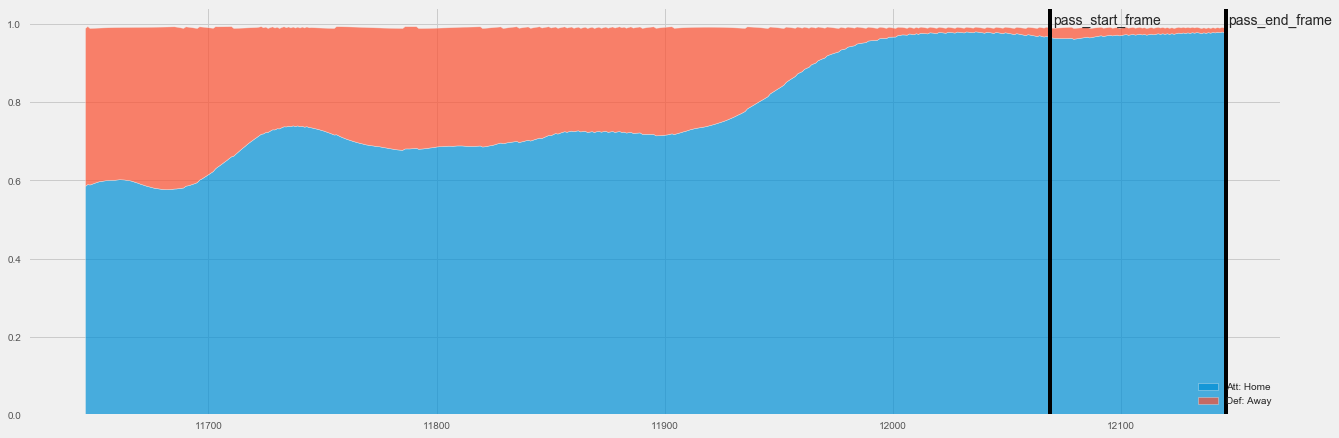

In [155]:
x = pitch_control_xy_df.index.values
y = np.array([pitch_control_xy_df.PPCFatt.values,
              pitch_control_xy_df.PPCFdef.values
             ])

fig,ax = plt.subplots(figsize=(20, 7))
plt.style.use('fivethirtyeight')
plt.stackplot(x,y, labels=['Att: Home','Def: Away'], alpha=0.7)
plt.legend(loc='lower right')

ax.axvline(pass_start_frame, ls='-',c = 'black')
ax.text(pass_start_frame+1,1., "pass_start_frame")

ax.axvline(pass_end_frame, ls='-',c = 'black')
ax.text(pass_end_frame+1,1., "pass_end_frame")
plt.show()



In [117]:
# [pitch_control_xy_df.loc[col].values for col in att_pc_cols][0]
# len([pitch_control_xy_df[col].values for col in att_pc_cols])
att_pc_cols

['Home_1_pc',
 'Home_10_pc',
 'Home_2_pc',
 'Home_3_pc',
 'Home_4_pc',
 'Home_5_pc',
 'Home_6_pc',
 'Home_7_pc',
 'Home_8_pc',
 'Home_9_pc']

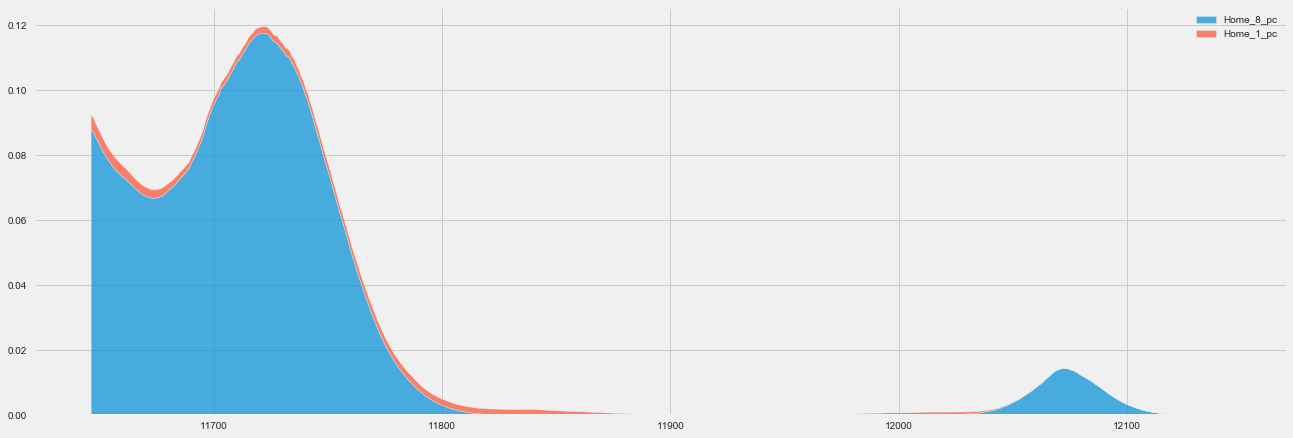

In [190]:
x = pitch_control_xy_df.index.values
y = np.array([
            pitch_control_xy_df['Home_8_pc'].fillna(0).values,
            pitch_control_xy_df['Home_1_pc'].fillna(0).values
             ])
# y = pitch_control_xy_df[att_pc_cols[1]].values

fig,ax = plt.subplots(figsize=(20, 7))
plt.style.use('fivethirtyeight')
plt.stackplot(x,y, labels=['Home_8_pc','Home_1_pc'], alpha=0.7)
plt.legend(loc='top left')

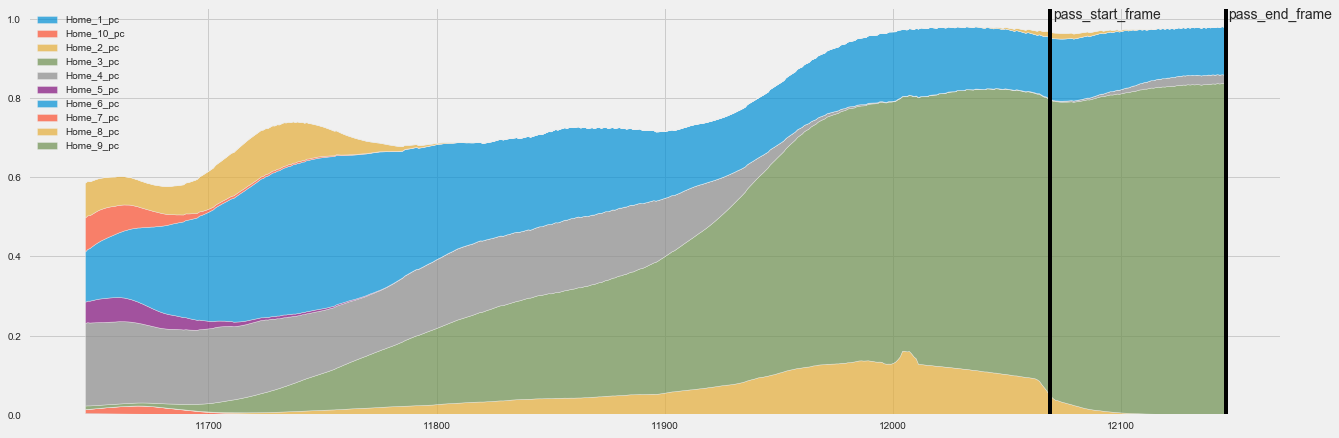

In [162]:
att_pc_cols = [c for c in pitch_control_xy_df.columns if c.startswith(team) & c.endswith('pc')]

x = pitch_control_xy_df.index.values
y = np.array([pitch_control_xy_df[col].fillna(0).values for col in att_pc_cols])
# y = pitch_control_xy_df[att_pc_cols[1]].values

fig,ax = plt.subplots(figsize=(20, 7))
plt.style.use('fivethirtyeight')
plt.stackplot(x,y, labels=att_pc_cols, alpha=0.7)
plt.legend(loc='top left')

ax.axvline(pass_start_frame, ls='-',c = 'black')
ax.text(pass_start_frame+1,1., "pass_start_frame")

ax.axvline(pass_end_frame, ls='-',c = 'black')
ax.text(pass_end_frame+1,1., "pass_end_frame")
plt.show()

## Let's try to plot the PPCF across 100 frames

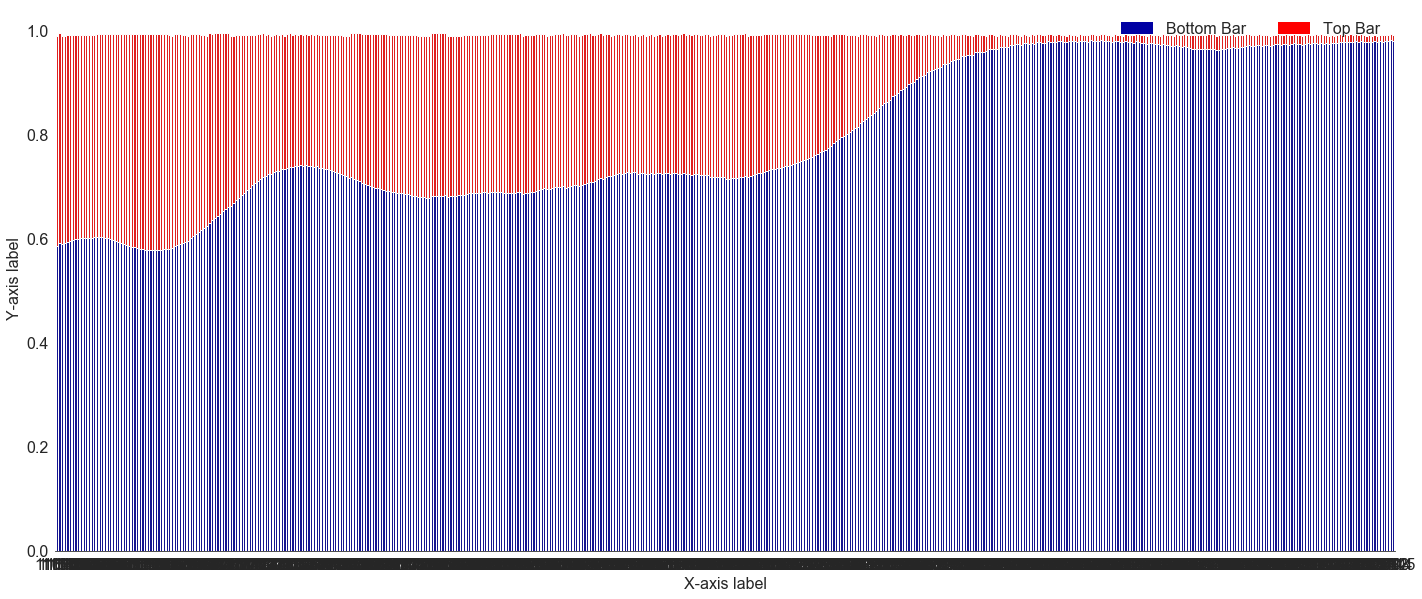

In [43]:
pitch_control_xy_df["total"] = pitch_control_xy_df.PPCFatt + pitch_control_xy_df.PPCFdef

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = pitch_control_xy_df.index, 
            y = pitch_control_xy_df.total.values, 
            color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = pitch_control_xy_df.index, 
                          y = pitch_control_xy_df.PPCFatt.values, 
                          color = "#0000A3")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Bottom Bar', 'Top Bar'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Y-axis label")
bottom_plot.set_xlabel("X-axis label")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)